# loading dependencies and setting up paths

In [1]:
import cv2 # openCV
import uuid # unique identifier for our images
import os
from pathlib import Path # path manager
import glob # globbing utility.
from tqdm import tqdm # for progress bar
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
images_path = Path('./Images')

# Data collection and labelling

Collect images of my face with mask

In [6]:
capture = cv2.VideoCapture(0)
# get the width and height of capture frame and convert it to integer
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
number_img = 0

while True:
    flag, faces_images = capture.read()
    faces_images_name = images_path/'with mask/{}.jpg'.format(str(uuid.uuid1()))
    if flag: 
        # If the camera is working flag == True
        cv2.imwrite(faces_images_name, faces_images)
        cv2.imshow('faces images', faces_images)
        number_img+=1
        if cv2.waitKey(2) == 27 or number_img ==1000:
            # collecting 1000 images
            break
        
capture.release()
cv2.destroyAllWindows()

Collect images of my face without mask

In [7]:
capture = cv2.VideoCapture(0)
# get the width and height of capture frame and convert it to integer
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
number_img = 0
while True:
    flag, faces_images = capture.read()
    faces_images_name = images_path/'without mask/{}.jpg'.format(str(uuid.uuid1()))
    if flag: 
        # If the camera is working flag == True
        cv2.imwrite(faces_images_name, faces_images)
        cv2.imshow('faces images', faces_images)
        number_img+=1
        if cv2.waitKey(2) == 27 or number_img ==1000:
                        # collecting 1000 images
            break
        
capture.release()
cv2.destroyAllWindows()

# Data Preparation

**Convert images into array using OpenCV**

In [71]:
def load_images_from_folder(folder):
    images = []
    for filename in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        # Resize the image for the DL model
        img = cv2.resize(img, (224, 224))
        if img is not None:
            images.append(img)
    return images

In [72]:
data_with_mask = np.array(load_images_from_folder(images_path/'with mask'))
data_without_mask = np.array(load_images_from_folder(images_path/'without mask'))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 218.57it/s]


In [73]:
data_with_mask.shape

(1000, 224, 224, 3)

In [74]:
data_without_mask.shape

(1000, 224, 224, 3)

**Create features shuffle them and create labels**

In [81]:
features = np.concatenate((data_with_mask, data_without_mask), axis=0)
np.random.shuffle(features)

In [85]:
# create label with 0 anywhere
label = np.zeros(features.shape[0])
# fix label for with mask data as 1
label [0:data_with_mask.shape[0]] = 1

In [86]:
label.shape, features.shape

((2000,), (2000, 224, 224, 3))

**Normalize the data**

In [87]:
features = features/255.0

In [89]:
np.save('features.npy', features)
np.save('label.npy', label)

# Training DL model

In [7]:
features = np.load('features.npy')
label = np.load('label.npy')

In [8]:
label.shape, features.shape

((1950,), (1950, 224, 224, 3))

**Download the pre-trained model: MobileNet**

In [10]:
model = tf.keras.applications.mobilenet.MobileNet() # pre-trained model

**Transfer learning**

In [11]:
base_input = model.layers[0].input

In [12]:
base_output = model.layers[-4].output

In [13]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)

In [14]:
new_model = keras.Model(inputs= base_input, outputs = final_output)

In [15]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

**Use the model**

In [16]:
new_model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [19]:
new_model.fit(features, label, epochs=20, validation_split = 0.15, shuffle=True)

Train on 1657 samples, validate on 293 samples
Epoch 1/20
1657/1657 [==============================] - 168s 102ms/sample - loss: 0.5677 - accuracy: 0.7224 - val_loss: 0.0484 - val_accuracy: 1.0000
Epoch 2/20
1657/1657 [==============================] - 178s 108ms/sample - loss: 0.4554 - accuracy: 0.7882 - val_loss: 0.1357 - val_accuracy: 0.9522
Epoch 3/20
1657/1657 [==============================] - 235s 142ms/sample - loss: 0.3791 - accuracy: 0.8256 - val_loss: 1.4709 - val_accuracy: 0.4164
Epoch 4/20
1657/1657 [==============================] - 232s 140ms/sample - loss: 0.2272 - accuracy: 0.9095 - val_loss: 5.8808 - val_accuracy: 0.0751
Epoch 5/20
1657/1657 [==============================] - 238s 144ms/sample - loss: 0.2482 - accuracy: 0.8968 - val_loss: 3.2346 - val_accuracy: 0.3072
Epoch 6/20
1657/1657 [==============================] - 233s 141ms/sample - loss: 0.1942 - accuracy: 0.9197 - val_loss: 0.3393 - val_accuracy: 0.8430
Epoch 7/20
1657/1657 [==============================]

To detect the face we will use haarcascade_frontal_face_default.xml

In [23]:
new_model.save("mask_detector.model")

# Predictions using model saved

In [8]:
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
model = keras.models.load_model("mask_detector.model")

> Before predicting we need to preprocess the image :
    >- Detect the face ( we will use haarcascade_frontalface_default.xml)
    >- resize it to the input size of our model (224, 224)
    >- reshape to 4 dimensions
    >- normalize
   

In [4]:
haar_data = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

mask detected


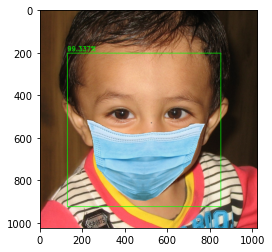

In [9]:
frame = cv2.imread('./Images/with_mask/00010_Mask.jpg')
# frame = cv2.imread('./Images/without_mask/00015.png')
# frame = cv2.imread('./Images/without mask/90529f12-8405-11eb-bc81-c809a8783858.jpg')
border_thickness = 2
green = (0, 255, 0)
red = (0, 0, 255)
faces = haar_data.detectMultiScale(frame)

for x, y, w, h in faces:
    face = frame[y:y+h, x:x+w, :]
    final_image = cv2.resize(face, (224,224))
    final_image = np.expand_dims(final_image, axis=0)
    final_image = final_image/255.0
    prediction = model.predict(final_image)[0, 0]
    prediction_percentage = "{0:.3%}".format(prediction)
#     print(prediction_percentage)
    if prediction > 0.5:
        print('mask detected')
        cv2.rectangle(frame, (x, y), (x+w, y+h), green, border_thickness)
        cv2.putText(frame, prediction_percentage, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, green, border_thickness)
    else: 
        print('no mask detected')
        cv2.rectangle(frame, (x, y), (x+w, y+h), red, border_thickness)
        cv2.putText(frame, prediction_percentage, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, red, border_thickness)

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


In [10]:
capture = cv2.VideoCapture(0)

while True:
    flag, faces_images = capture.read()
    faces = haar_data.detectMultiScale(faces_images)
    if flag:
        for x, y, w, h in faces:
            face = faces_images[y:y+h, x:x+w, :]
            final_image = cv2.resize(face, (224,224))
            final_image = np.expand_dims(final_image, axis=0)
            final_image = final_image/255.0
            prediction = model.predict(final_image)[0, 0]
            prediction_percentage = "{0:.3%}".format(prediction)
        #     print(prediction_percentage)
            if prediction > 0.5:
#                 print('mask detected')
                cv2.rectangle(faces_images, (x, y), (x+w, y+h), green, border_thickness)
                cv2.putText(faces_images, prediction_percentage, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, green, border_thickness)
            else: 
#                 print('no mask detected')
                cv2.rectangle(faces_images, (x, y), (x+w, y+h), red, border_thickness)
                cv2.putText(faces_images, prediction_percentage, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, red, border_thickness)
        cv2.imshow('results', faces_images)
        # 27 is the ASCII number of Escape button
        if cv2.waitKey(2) == 27:
            break
capture.release()
cv2.destroyAllWindows()